In [3]:
#!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
import h2o
from sklearn.model_selection import train_test_split
import pandas as pd

In [25]:
from h2o.automl import H2OAutoML
from fi_utils import load_dataset
from plt_utils import plot_confusion_matrix
from benchmark_utils import timer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np


h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 8 mins
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.4
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_bruno_bs3i0n
H2O cluster total nodes:,1
H2O cluster free memory:,3.230 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [5]:
X, y, class_names = load_dataset()
y_dumm=pd.get_dummies(y)



In [7]:
all_models = [
        ["0", y_dumm[0]],
        ("1", y_dumm[1]),
        ("2", y_dumm[2])
    ]



In [8]:

all_preds = []
for model in all_models:
    X["Pos"] = model[1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, model[1], 
                                                    test_size=0.20, 
                                                    random_state=42)
    
    train = h2o.H2OFrame.from_python(X_train)
    test = h2o.H2OFrame.from_python(X_test)
    

    # Identify predictors and response
    x = train.columns
    y = "Pos"


    # Run AutoML for 20 base models (limited to 1 hour max runtime by default)
    aml = H2OAutoML(max_models=20, seed=1)
    aml.train(x=x, y=y, training_frame=train)
    preds = aml.predict(test)
    all_preds.append(preds)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


/home/bruno/anaconda3/envs/fifa-ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


Acc:  0.8978672273956143
Figure(720x504)


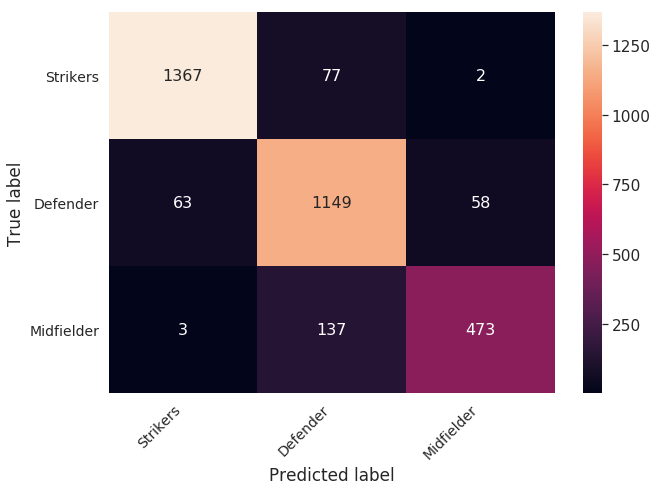

In [27]:
X, y, class_names = load_dataset()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)

teste = all_preds[0].as_data_frame()

teste["predic1"] = all_preds[1].as_data_frame()
teste["predic2"] = all_preds[2].as_data_frame()


preds_final = [np.argmax(x) for x in teste.as_matrix()]


print("Acc: ", accuracy_score(y_test,preds_final))

cf = confusion_matrix(y_test, preds_final)

print(plot_confusion_matrix(cf,class_names=class_names))




## One vs all classification for multiclass problem with H2O

